# Notebook for final analysis

In [ ]:
# TODO: Sjekke over optimeringsmodellen --> done
# TODO: Sjekke data for startsbelegg --> done(ish)
# TODO: fikse shift_pr_day delen av simuleringen --> done
# TODO: fikse kalkuleringen av belegg kun etter filtrering av dataset slik at man ikke dobbler antallet + endre demand til kun eksisterende på post --> done
# TODO: Nye constraints optimeringsmodellen
# TODO: Simulere antall pasienter inn også, ikke bare liggetiden --> done

## Import necessary libraries

In [1]:
import pandas as pd
from data.data_functions import *
from simulation.simulation_models import *
from optimization.optimization import *
import warnings

warnings.filterwarnings("ignore")

## Henter nødvendige dataset

### Timesbasert data historisk

In [2]:
dfs_dict = read_folder_to_dfs("./data/timesdata")
fin_data_hourly = create_hourly_obt(dfs_dict)
# fin_data_hourly["Belegg"] = fin_data_hourly.apply(calculate_patients, axis=1)
fin_data_hourly["skift_type"] = fin_data_hourly.apply(add_shift_type, axis=1)
fin_data_hourly.head(10)

,År,Måned,Uke,Dag,DatoTid,Timer,post,helg,Antall inn på post,Antall pasienter ut av Post,skift_type
0,2020,January,1,Wednesday,2020-01-01 00:00:00,0,kirurgisk,0,1.0,0.0,natt
1,2020,January,1,Wednesday,2020-01-01 00:00:00,0,medisinsk,0,0.0,0.0,natt
2,2020,January,1,Wednesday,2020-01-01 01:00:00,1,kirurgisk,0,1.0,0.0,natt
3,2020,January,1,Wednesday,2020-01-01 01:00:00,1,medisinsk,0,1.0,0.0,natt
4,2020,January,1,Wednesday,2020-01-01 02:00:00,2,medisinsk,0,1.0,0.0,natt
5,2020,January,1,Wednesday,2020-01-01 02:00:00,2,kirurgisk,0,0.0,0.0,natt
6,2020,January,1,Wednesday,2020-01-01 03:00:00,3,kirurgisk,0,0.0,0.0,natt
7,2020,January,1,Wednesday,2020-01-01 03:00:00,3,medisinsk,0,0.0,0.0,natt
8,2020,January,1,Wednesday,2020-01-01 04:00:00,4,kirurgisk,0,0.0,0.0,natt
9,2020,January,1,Wednesday,2020-01-01 04:00:00,4,medisinsk,0,1.0,0.0,natt


In [ ]:
# fin_hf_med_path = "./data/med_pasientstrøm_time_2024.xlsx"
# fin_hf_kir_path = "./data/kir_pasientstrøm_time_2024.xlsx"

# fin_data_hourly = create_hourly_dataframe(fin_hf_med_path, fin_hf_kir_path)



# fin_data_hourly["Belegg"] = fin_data_hourly.apply(calculate_patients, axis=1)
# fin_data_hourly["skift_type"] = fin_data_hourly.apply(add_shift_type, axis=1)

# fin_data_hourly.head(10)

### Timesbasert prediksjoner

In [3]:
fin_data_hourly_med = fin_data_hourly[fin_data_hourly["post"]=="medisinsk"]
fin_data_hourly_kir = fin_data_hourly[fin_data_hourly["post"]=="kirurgisk"]

fin_data_hourly_med["Belegg"] = fin_data_hourly_med.apply(calculate_patients, axis=1)
fin_data_hourly_kir["Belegg"] = fin_data_hourly_kir.apply(calculate_patients, axis=1)

next_year_med = create_forecast_hourly(fin_data_hourly_med, "medisinsk")
next_year_kir = create_forecast_hourly(fin_data_hourly_kir, "kirurgisk")

next_year = pd.concat([next_year_med, next_year_kir], axis=0).sort_values("DatoTid").reset_index()
next_year.drop(["index"], axis=1, inplace=True)
next_year["skift_type"] = next_year.apply(add_shift_type, axis=1)

fin_data_hourly["Prediksjoner pasientstrøm"] = np.nan
fin_data_hourly["Prediksjoner belegg"] = np.nan

fin_data_hourly = pd.concat([fin_data_hourly_med, fin_data_hourly_kir, next_year], axis=0).sort_values("DatoTid").reset_index()
fin_data_hourly.drop(["index"], axis=1, inplace=True)
fin_data_hourly

,År,Måned,Uke,Dag,DatoTid,Timer,post,helg,Antall inn på post,Antall pasienter ut av Post,skift_type,Belegg,Prediksjoner pasientstrøm,Prediksjoner belegg
0,2020,January,1,Wednesday,2020-01-01 00:00:00,0,medisinsk,0,0.0,0.0,natt,0.0,NaN,NaN
1,2020,January,1,Wednesday,2020-01-01 00:00:00,0,kirurgisk,0,1.0,0.0,natt,13.0,NaN,NaN
2,2020,January,1,Wednesday,2020-01-01 01:00:00,1,kirurgisk,0,1.0,0.0,natt,14.0,NaN,NaN
3,2020,January,1,Wednesday,2020-01-01 01:00:00,1,medisinsk,0,1.0,0.0,natt,1.0,NaN,NaN
4,2020,January,1,Wednesday,2020-01-01 02:00:00,2,medisinsk,0,1.0,0.0,natt,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97322,2025,October,42,Tuesday,2025-10-14 22:00:00,22,medisinsk,0,NaN,NaN,kveld,NaN,0.0,25.0
97323,2025,October,42,Tuesday,2025-10-14 23:00:00,23,kirurgisk,0,NaN,NaN,natt,NaN,0.0,19.0
97324,2025,October,42,Tuesday,2025-10-14 23:00:00,23,medisinsk,0,NaN,NaN,natt,NaN,0.0,23.0
97325,2025,October,42,Wednesday,2025-10-15 00:00:00,0,medisinsk,0,NaN,NaN,natt,NaN,1.0,1.0


### Historisk data daglig aggregering

In [4]:
path = "./data/fin_hf_datagrunnlag.xlsx"
fin_data_hist = datalast_behandling(path)
fin_data_hist.head(10)

,År,Måned,Dato,Antall inn på post,Antall pasienter ut av Post,Belegg,Antall liggedogn,Senger normert,Beleggsprosent,Gjennomsnitts belegg,Antall senger i bruk,post,helg
0,2022,januar,2022-01-01,3,3,22.291667,22,33,0.675505,22.291667,33,medisinsk,1
1,2022,januar,2022-01-01,2,0,12.625000,12,22,0.742647,12.625000,17,kirurgisk,1
2,2022,januar,2022-01-02,10,6,25.416667,23,33,0.770202,25.416667,33,medisinsk,1
3,2022,januar,2022-01-02,5,3,14.625000,13,22,0.860294,14.625000,17,kirurgisk,1
4,2022,januar,2022-01-03,5,3,27.916667,27,33,0.845960,27.916667,33,medisinsk,0
5,2022,januar,2022-01-03,7,4,16.166667,16,22,0.734848,16.166667,22,kirurgisk,0
6,2022,januar,2022-01-04,11,6,28.583333,27,33,0.866162,28.583333,33,medisinsk,0
7,2022,januar,2022-01-04,4,4,18.458333,17,22,0.839015,18.458333,22,kirurgisk,0
8,2022,januar,2022-01-05,12,20,32.250000,33,33,0.977273,32.250000,33,medisinsk,0
9,2022,januar,2022-01-05,12,10,20.541667,18,22,0.933712,20.541667,22,kirurgisk,0


### Predikerte data daglig aggregering

In [5]:
path_pred = "./forecasting/excel_models/fin_hf_prediksjoner.xlsx"
sheetname_med = "hammerfest_medisinsk"
sheetname_kir = "hammerfest_kirurgisk"
forecasted_demand = create_forecast_dataset(path_pred, sheetname_med, sheetname_kir)

fin_data = pd.concat([fin_data_hist, forecasted_demand], axis=0).sort_values("Dato").reset_index()
fin_data.drop(["index"], axis=1, inplace=True)
fin_data

,År,Måned,Dato,Antall inn på post,Antall pasienter ut av Post,Belegg,Antall liggedogn,Senger normert,Beleggsprosent,Gjennomsnitts belegg,Antall senger i bruk,post,helg,Prediksjoner pasientstrøm,Prediksjoner belegg
0,2022,januar,2022-01-01,3.0,3.0,22.291667,22.0,33.0,0.675505,22.291667,33.0,medisinsk,1,NaN,NaN
1,2022,januar,2022-01-01,2.0,0.0,12.625000,12.0,22.0,0.742647,12.625000,17.0,kirurgisk,1,NaN,NaN
2,2022,januar,2022-01-02,10.0,6.0,25.416667,23.0,33.0,0.770202,25.416667,33.0,medisinsk,1,NaN,NaN
3,2022,januar,2022-01-02,5.0,3.0,14.625000,13.0,22.0,0.860294,14.625000,17.0,kirurgisk,1,NaN,NaN
4,2022,januar,2022-01-03,5.0,3.0,27.916667,27.0,33.0,0.845960,27.916667,33.0,medisinsk,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,2025,12,2025-12-29,8.0,NaN,23.000000,NaN,NaN,NaN,NaN,NaN,medisinsk,0,8.0,25.0
2881,2025,12,2025-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kirurgisk,0,4.0,14.0
2882,2025,12,2025-12-30,7.0,NaN,22.000000,NaN,NaN,NaN,NaN,NaN,medisinsk,0,8.0,24.0
2883,2025,12,2025-12-31,6.0,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,medisinsk,0,7.0,22.0


### Setter felles parametere

In [6]:
# fin_data_hourly[(fin_data_hourly['År'] == 2024) & (fin_data_hourly['post'] == 'medisinsk') & (fin_data_hourly['Måned'] == 'May')]
fin_data_hourly[(fin_data_hourly['År'] == 2024) & (fin_data_hourly['post'] == 'medisinsk')]

,År,Måned,Uke,Dag,DatoTid,Timer,post,helg,Antall inn på post,Antall pasienter ut av Post,skift_type,Belegg,Prediksjoner pasientstrøm,Prediksjoner belegg
69726,2024,January,1,Monday,2024-01-01 00:00:00,0,medisinsk,0,2.0,0.0,natt,14.0,NaN,NaN
69728,2024,January,1,Monday,2024-01-01 01:00:00,1,medisinsk,0,0.0,0.0,natt,14.0,NaN,NaN
69730,2024,January,1,Monday,2024-01-01 02:00:00,2,medisinsk,0,0.0,0.0,natt,14.0,NaN,NaN
69732,2024,January,1,Monday,2024-01-01 03:00:00,3,medisinsk,0,1.0,0.0,natt,15.0,NaN,NaN
69734,2024,January,1,Monday,2024-01-01 04:00:00,4,medisinsk,0,1.0,0.0,natt,16.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83540,2024,October,42,Monday,2024-10-14 19:00:00,19,medisinsk,0,1.0,0.0,kveld,16.0,NaN,NaN
83541,2024,October,42,Monday,2024-10-14 20:00:00,20,medisinsk,0,1.0,0.0,kveld,17.0,NaN,NaN
83544,2024,October,42,Monday,2024-10-14 21:00:00,21,medisinsk,0,2.0,0.0,kveld,19.0,NaN,NaN
83545,2024,October,42,Monday,2024-10-14 22:00:00,22,medisinsk,0,0.0,0.0,kveld,19.0,NaN,NaN


In [6]:
data = fin_data_hourly
post = "medisinsk"
weekend = False
predictions = False
year = 2024
avg_length_of_stay = 3  # Gjennomsnittlig liggetid (dager)
# shifts_per_day = 3  # Antall skift per dag
iterations = 1000  # Antall simuleringer
month = ["May", "June", "July", "August", "September", "October"]
shift_type = "dag"
scenario = None
total_beds = 26 # 26 hvis ukedag eller helg med, kir: hverdag = 22, helg = 17
curr_sit = 12
# Med post: hverdag: dag: 12, kveld: 12, natt:4 
# Med post: Helg: 9, 9, 4
# Kir post: Hverdag: 10, 8, 3
# Kir post: Helg: 8, 7, 3

# Tilbudsiden

## Optimeringsmodell for optimalt bemanningsnivå

### Optimaliseringsdata, Modellbygging & Resultater

In [7]:
data_opt = opt_dataset(dataset=data, post=post, year=year, shift_type=shift_type, month=month, weekend=weekend, predictions=predictions)
data_opt = data_opt.apply(nightshift_weight, axis=1)

# Parameters for specific model
df_index = data_opt.DatoTid
demand = round(data_opt["Belegg"])
MaxStaff = 15
PPS = 3
availability = 40
ServiceLevel = 0.8

## Scenarioer: 1) Helligdager og offentlige eventer, 2) Høytider, 3) Ulykke, 4) Krig
# Her må det legges til endring i pasientstrøm og belegg pr. dag i functionene direkte, pluss endring i MaxStaff, PPS, availability og service_level
# for å simulere de ulike scenarioene 

model = labor_scheduling(df_index, demand, MaxStaff, PPS, availability, ServiceLevel)
result, status, obj, staff_allocated = optimize_staffing(model)
data_opt["staff_allocated"] = staff_allocated
data_opt = data_opt.apply(adjust_staff, axis=1)
display(data_opt) 

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JOACHI~1\AppData\Local\Temp\tmpjo48n4es.glpk.raw --wglp
 C:\Users\JOACHI~1\AppData\Local\Temp\tmppwq18pmy.glpk.glp --cpxlp C:\Users\JOACHI~1\AppData\Local\Temp\tmpdf20x6dw.pyomo.lp
Reading problem data from 'C:\Users\JOACHI~1\AppData\Local\Temp\tmpdf20x6dw.pyomo.lp'...
2856 rows, 952 columns, 2856 non-zeros
952 integer variables, none of which are binary
14290 lines were read
Writing problem data to 'C:\Users\JOACHI~1\AppData\Local\Temp\tmppwq18pmy.glpk.glp'...
11427 lines were written
GLPK Integer Optimizer 5.0
2856 rows, 952 columns, 2856 non-zeros
952 integer variables, none of which are binary
Preprocessing...
Objective value =   5.107000000e+03
INTEGER OPTIMAL SOLUTION FOUND BY MIP PREPROCESSOR
Time used:   0.0 secs
Memory used: 1.4 Mb (1486356 bytes)
Writing MIP solution to 'C:\Users\JOACHI~1\AppData\Local\Temp\tmpjo48n4es.glpk.raw'...
3817 lines were written


,DatoTid,Timer,skift_type,Antall inn på post,Belegg,staff_allocated
0,2024-05-01 07:00:00,7,dag,1.0,17.0,5.0
1,2024-05-01 08:00:00,8,dag,0.0,17.0,5.0
2,2024-05-01 09:00:00,9,dag,0.0,17.0,5.0
3,2024-05-01 10:00:00,10,dag,0.0,17.0,5.0
4,2024-05-01 11:00:00,11,dag,0.0,17.0,5.0
...,...,...,...,...,...,...
947,2024-10-14 10:00:00,10,dag,1.0,15.0,4.0
948,2024-10-14 11:00:00,11,dag,0.0,15.0,4.0
949,2024-10-14 12:00:00,12,dag,0.0,15.0,4.0
950,2024-10-14 13:00:00,13,dag,0.0,14.0,4.0


### Visualize results

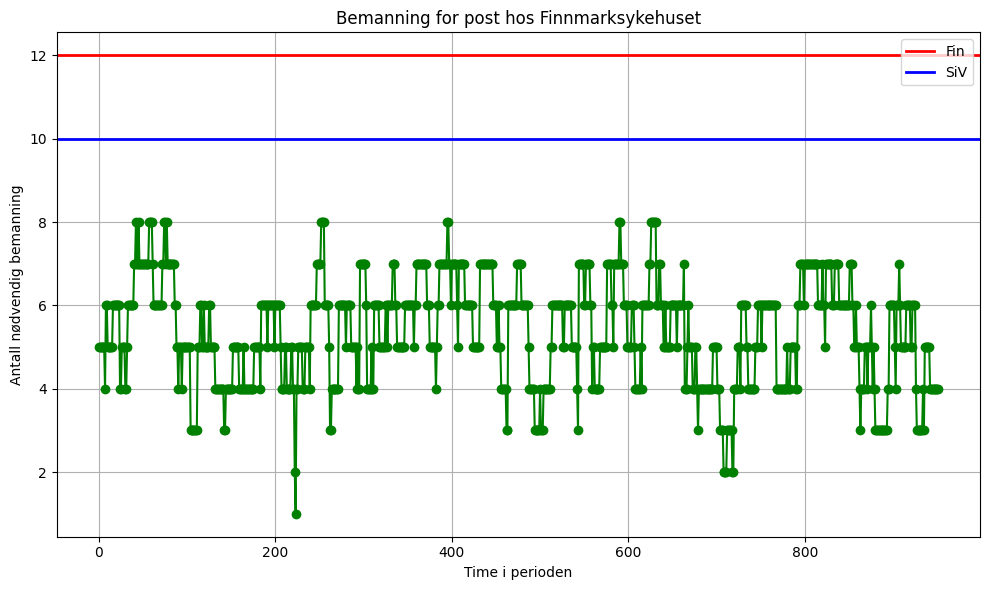

In [9]:
# Med post: hverdag: dag: 12, kveld: 12, natt:4 
# Med post: Helg: 9, 9, 4
# Kir post: Hverdag: 10, 8, 3
# Kir post: Helg: 8, 7, 3
fin = 12

# Med post: hverdag: dag: 10, kveld: 7, natt:4 
# Med post: Helg: 9, 7, 4
# Kir post: Hverdag: 10, 8, 4
# Kir post: Helg: 8, 8, 3
siv = 10

# Med post: hverdag: dag: 16, kveld: 9, natt:6 
# Med post: Helg: ?, ?, ?
# Kir post: Hverdag: 18, 11, 5
# Kir post: Helg: ?, ?, ?
unn = 9
staff_allocated = data_opt["staff_allocated"].tolist()
staff_opt_plot(staff_allocated, fin, siv, unn, dag=True)

## Optimeringsmodell for minimering av kostnader

### Preprocessing

In [ ]:
import math
data_opt["HourCost"] = data_opt.apply(lambda x: hourly_cost_calc(x), axis=1)
opt_cost_data = data_opt.groupby(["Timer", "skift_type"])[["staff_allocated", "HourCost"]].mean().reset_index()
opt_cost_data["staff_allocated"] = opt_cost_data["staff_allocated"].apply(lambda x: math.ceil(x))
hour_list = list(opt_cost_data["Timer"])
numEmp_list = [element for element in opt_cost_data["staff_allocated"]]
cost_list = [int(element) for element in opt_cost_data["HourCost"]]

df_index = hour_list
numEmp = numEmp_list
shifts = ["dag", "kveld", "natt"]
shiftLengths = [4,5,6,7,8,9,10,11,12]
hourly_cost = cost_list

### Model

In [ ]:
shifts, cost = opt_cost_model(df_index=df_index, numEmp=numEmp, shifts=shifts, shiftLengths=shiftLengths, hourly_cost=hourly_cost)

## Simulering Skiftdesign for Over- og Underbemanninger

### Input data

In [8]:
# Parameter for specific model
staff_needed = data_opt["staff_allocated"]
staff_needed = pd.Series(staff_needed)
curr_sit = 12
shifts_per_day = 24  # Antall timer per dag
## Scenarioer: 1) Helligdager og offentlige eventer, 2) Høytider, 3) Ulykke, 4) Krig, 5) evt. to shift helg istedet for 3 (?)
# Her må det legges til endring i pasientstrøm og belegg pr. dag i functionene direkte, pluss endring i MaxStaff, PPS, availability og service_level (fra optimeringsdelen),
# og avg_length_of_stay, (shifts_per_day) for å simulere de ulike scenarioene  

### Simulering under/overbemannede skift

In [9]:
understaffed_shifts, overstaffed_shifts, total_shifts, staffed_shifts_data = over_under_staffed_shifts(data=data,
                                                                                                       staff_needed= staff_needed, 
                                                                                                       avg_length_of_stay= avg_length_of_stay, 
                                                                                                       shifts_per_day= shifts_per_day, 
                                                                                                       iterations= iterations, 
                                                                                                       post=post, 
                                                                                                       weekend=weekend, 
                                                                                                       predictions=predictions, 
                                                                                                       year=year,
                                                                                                       month=month,
                                                                                                       shift_type=shift_type,
                                                                                                       curr_sit = curr_sit)


prosent_underbemannet_skift = understaffed_shifts / total_shifts * 100
prosent_overbemannet_skift = overstaffed_shifts / total_shifts * 100

# Resultat: Hvor ofte er skift underbemannet?
print(f"Prosentandel timer med underbemanning: {prosent_underbemannet_skift:.2f}%")
print(f"Prosentandel timer med overbemanning: {prosent_overbemannet_skift:.2f}%")
print(f"Prosentandel timer med riktig bemanning: {(100 - (prosent_underbemannet_skift + prosent_overbemannet_skift)):.2f}%")

Prosentandel timer med underbemanning: 4.89%
Prosentandel timer med overbemanning: 91.75%
Prosentandel timer med riktig bemanning: 3.36%


### Visualiserte resultater

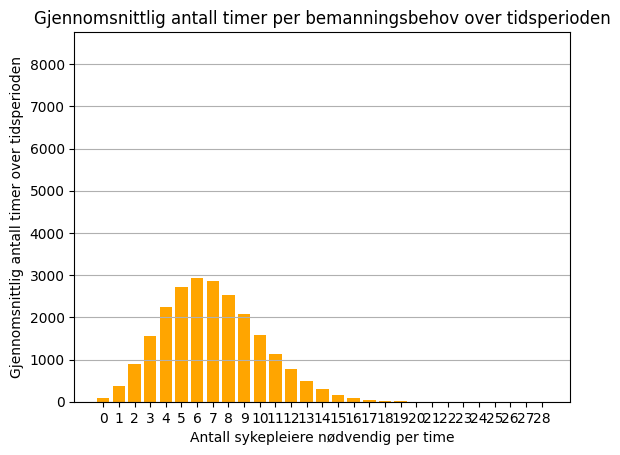

In [10]:
under_over_staffing_plot(staffed_shifts_data, iterations, shifts_per_day)

# Etterspørselsiden

## Monte Carlo Simulering Overbelastning, Belegg, og Ventetid

### Input data

In [13]:
# Model-specific parameters
data = fin_data

## Scenarioer: 1) Helligdager og offentlige eventer, 2) Høytider, 3) Ulykke, 4) Krig
# Her må det legges til endring i pasientstrøm og belegg pr. dag i functionene direkte, pluss endring i MaxStaff, PPS, availability og service_level (fra optimeringsdelen),
# total_beds, og average_stay for å simulere de ulike scenarioene  

### Simuleringsresultater

In [14]:
data, avg_overload_days, avg_occupancy_percentage, waiting_probability, all_overload_days, all_occupancy_percents = monte_carlo_simulation(data=data, 
                                                                                                                                           total_beds=total_beds, 
                                                                                                                                           average_stay= avg_length_of_stay, 
                                                                                                                                           num_simulations= iterations, 
                                                                                                                                           post= post, 
                                                                                                                                           year= year)

# Print resultater
print(f"Gjennomsnittlig antall dager med overbelastning per år: {avg_overload_days:.2f} dager")
print(f"Gjennomsnittlig beleggsprosent over året: {avg_occupancy_percentage:.2f}%")
print(f"Sannsynligheten for at pasienter må vente på en seng: {waiting_probability:.2%}")

Gjennomsnittlig antall dager med overbelastning per år: 76.10 dager
Gjennomsnittlig beleggsprosent over året: 85.47%
Sannsynligheten for at pasienter må vente på en seng: 14.24%


### Visualiserte resultater

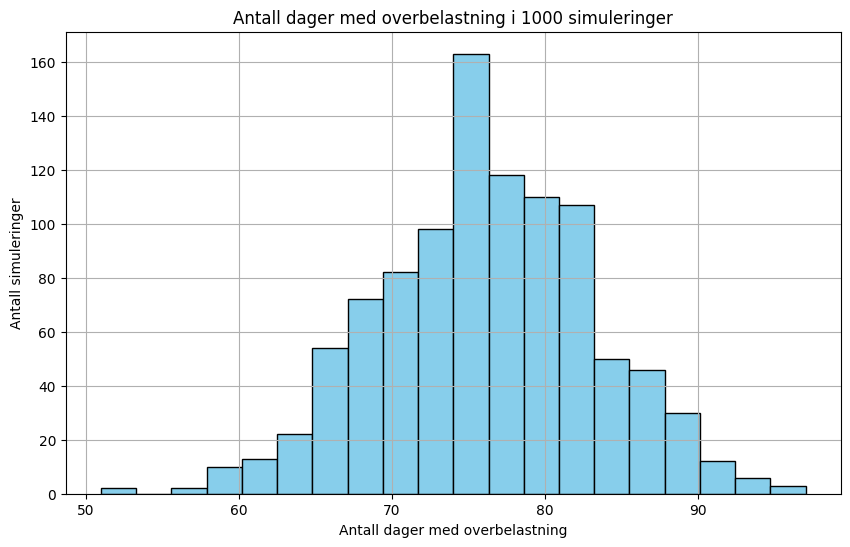

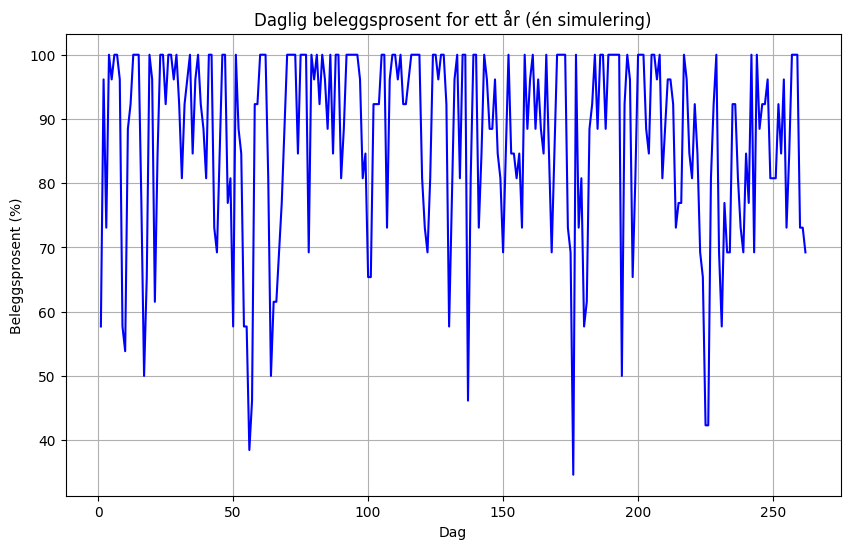

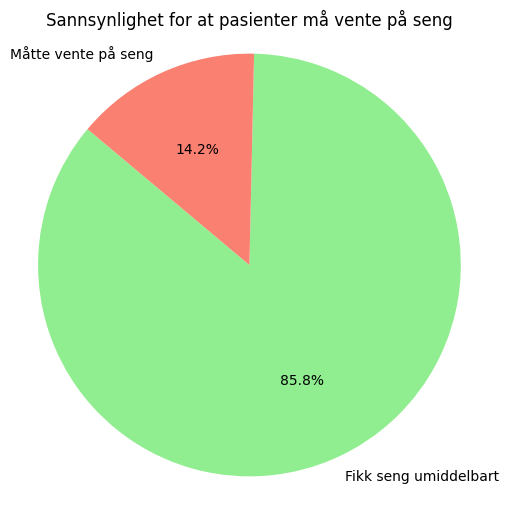

In [15]:
monte_carlo_dager_overbelastning(all_overload_days)
monte_carlo_beleggsprosent(data, all_occupancy_percents)
monte_carlo_waiting_probability(waiting_probability)

## Ad-Hoc Analyser

### Analyse av størst trykk

In [9]:
fin_data_hourly_24 = fin_data_hourly[(fin_data_hourly["År"] == 2024)] # & (fin_data_hourly["post"] == "kirurgisk") & (fin_data_hourly["helg"] == 1)
fin_data_hourly_24["Demand"] = fin_data_hourly_24["Antall inn på post"] + fin_data_hourly_24["Belegg"]
fin_data_hourly_24.loc[fin_data_hourly_24['skift_type'] == 'natt', 'Demand'] *= 0.33

In [10]:
fin_data_hourly_24

,År,Måned,Uke,Dag,DatoTid,Timer,post,helg,Antall inn på post,Antall pasienter ut av Post,Belegg,skift_type,Prediksjoner pasientstrøm,Prediksjoner belegg,Demand
69725,2024,January,1,Monday,2024-01-01 00:00:00,0,kirurgisk,0,0.0,0.0,0.0,natt,NaN,NaN,0.00
69726,2024,January,1,Monday,2024-01-01 00:00:00,0,medisinsk,0,2.0,0.0,2.0,natt,NaN,NaN,1.32
69727,2024,January,1,Monday,2024-01-01 01:00:00,1,kirurgisk,0,0.0,0.0,2.0,natt,NaN,NaN,0.66
69728,2024,January,1,Monday,2024-01-01 01:00:00,1,medisinsk,0,0.0,0.0,2.0,natt,NaN,NaN,0.66
69729,2024,January,1,Monday,2024-01-01 02:00:00,2,kirurgisk,0,0.0,0.0,2.0,natt,NaN,NaN,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83544,2024,October,42,Monday,2024-10-14 21:00:00,21,kirurgisk,0,0.0,0.0,24.0,kveld,NaN,NaN,24.00
83545,2024,October,42,Monday,2024-10-14 22:00:00,22,medisinsk,0,0.0,0.0,24.0,kveld,NaN,NaN,24.00
83546,2024,October,42,Monday,2024-10-14 22:00:00,22,kirurgisk,0,0.0,0.0,24.0,kveld,NaN,NaN,24.00
83547,2024,October,42,Monday,2024-10-14 23:00:00,23,kirurgisk,0,0.0,0.0,24.0,natt,NaN,NaN,7.92


In [11]:
def adhoc_plot(data: pd.DataFrame, tids_granulitetsniv: str = "Timer", value: str = "Demand", skift_type: str = None, aggregation_level: str = "mean"):
    # Group by timer og post, og finn gjennomsnittet av etterspørselen
    week_order = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ]

    if aggregation_level == "mean":
        avg_patients_per_hour = data.groupby([tids_granulitetsniv, 'post'])[value].mean().reset_index()
    elif aggregation_level == "sum":
        if tids_granulitetsniv == "Dag":
            avg_patients_per_hour = fin_data_hourly_24.groupby([tids_granulitetsniv, 'post'])[value].sum().reset_index()
            avg_patients_per_hour[tids_granulitetsniv] = pd.Categorical(avg_patients_per_hour[tids_granulitetsniv], categories=week_order, ordered=True)
            avg_patients_per_hour = avg_patients_per_hour.sort_values(tids_granulitetsniv)
        else:
            avg_patients_per_hour = data.groupby([tids_granulitetsniv, 'post'])[value].sum().reset_index()
    
    if skift_type is None:
        avg = data[value].mean()    
    else:
        avg = data[data["skift_type"] == skift_type][value].mean()
    print(f"Gjennomsnittlig {value} målt i {tids_granulitetsniv}: {avg} pasienter pr {tids_granulitetsniv}")
   
    # Pivot for lettere plotting
    pivot_data = avg_patients_per_hour.pivot(index=tids_granulitetsniv, columns='post', values=value)
    pivot_data.plot(kind='bar', width=0.8, figsize=(12, 6), color=['skyblue','salmon'])
    plt.title(f"Gjennomsnittlig {value} per post i 2024")
    plt.xlabel(f"{tids_granulitetsniv} i tidsperioden")
    plt.ylabel("Gjennomsnittlig antall pasienter")
    plt.xticks(rotation=0)
    plt.legend(title="Post")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Gjennomsnittlig Antall pasienter ut av Post målt i Dag: 0.4125434027777778 pasienter pr Dag


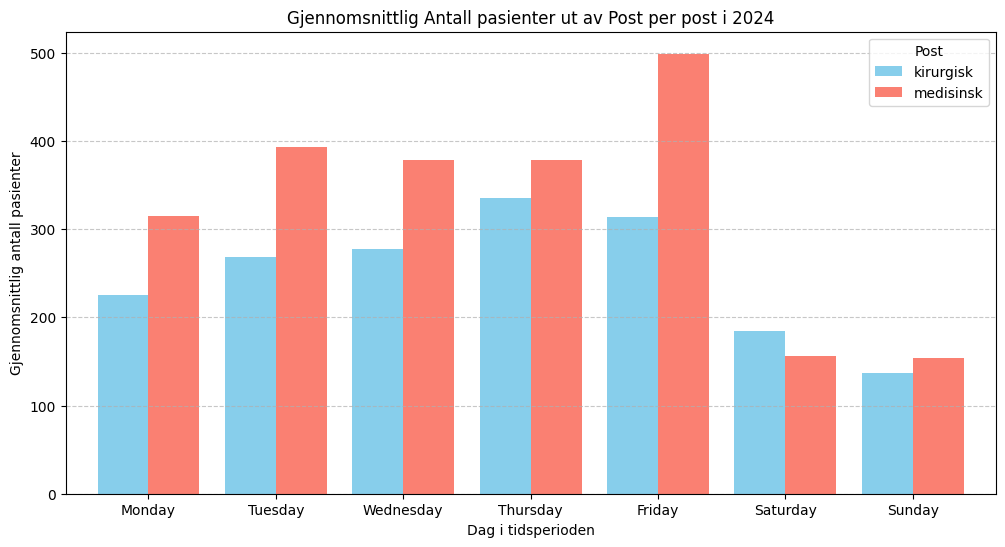

In [13]:
avg = adhoc_plot(data=fin_data_hourly_24, tids_granulitetsniv="Dag", value="Antall pasienter ut av Post", skift_type="dag", aggregation_level="sum")

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by timer og post, og finn gjennomsnittet av etterspørselen
avg_patients_per_hour = fin_data_hourly_24.groupby(['Dag', 'post'])['Demand'].mean().reset_index()
display(avg_patients_per_hour)
# Pivot for lettere plotting
# pivot_data = avg_patients_per_hour.pivot(index='Måned', columns='post', values='Antall pasienter ut av Post')
# pivot_data.plot(kind='bar', width=0.8, figsize=(12, 6), color=['skyblue','salmon'])
# plt.title("Gjennomsnittlig pasienttrykk per post i 2024")
# plt.xlabel("Time på dagen")
# plt.ylabel("Gjennomsnittlig antall pasienter")
# plt.xticks(rotation=0)
# plt.legend(title="Post")
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.show()


,Dag,post,Demand
0,Friday,kirurgisk,13.588902
1,Friday,medisinsk,13.587266
2,Monday,kirurgisk,17.292173
3,Monday,medisinsk,17.367708
4,Saturday,kirurgisk,11.135020
5,Saturday,medisinsk,11.190783
6,Sunday,kirurgisk,13.405600
7,Sunday,medisinsk,13.328974
8,Thursday,kirurgisk,17.183313
9,Thursday,medisinsk,17.333171


In [57]:
fin_data_hourly_24[fin_data_hourly_24["skift_type"] == "dag"]["Demand"].mean()

22.193359375

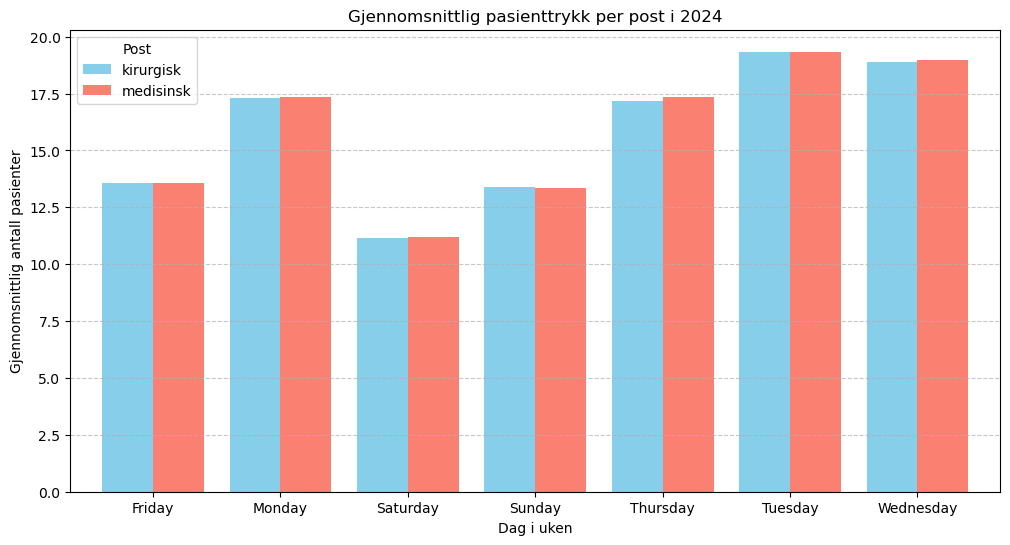

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by timer og post, og finn gjennomsnittet av etterspørselen
week_order = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]
avg_patients_per_hour = fin_data_hourly_24.groupby(['Dag', 'post'])['Demand'].mean().reset_index()
avg_patients_per_hour['Dag'] = pd.Categorical(avg_patients_per_hour['Dag'], categories=week_order, ordered=True)
avg_patients_per_hour = avg_patients_per_hour.sort_values('Dag')

# Pivot for lettere plotting
pivot_data = avg_patients_per_hour.pivot(index='Dag', columns='post', values='Demand')
pivot_data.plot(kind='bar', width=0.8, figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title("Gjennomsnittlig pasienttrykk per post i 2024")
plt.xlabel("Dag i uken")
plt.ylabel("Gjennomsnittlig antall pasienter")
plt.xticks(rotation=0)
plt.legend(title="Post")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


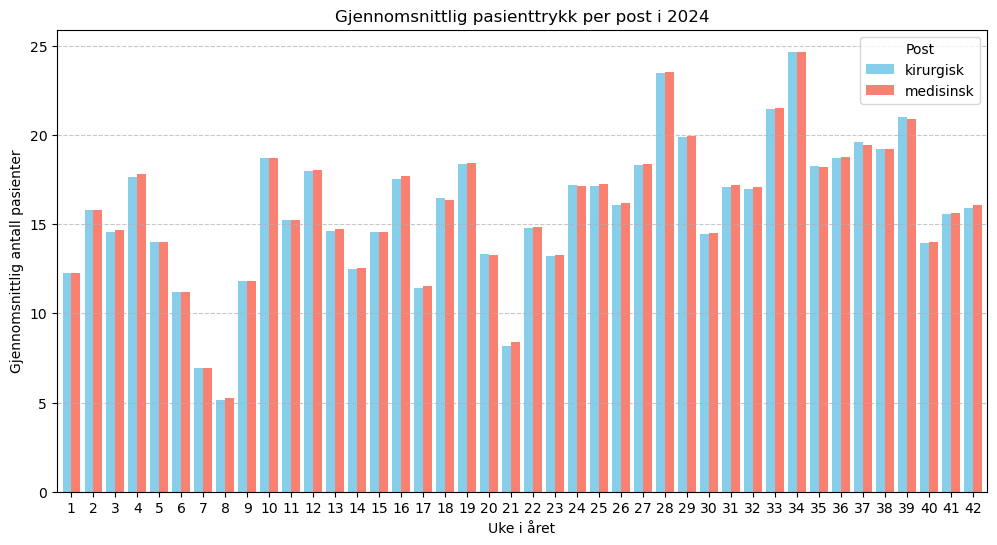

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by timer og post, og finn gjennomsnittet av etterspørselen
avg_patients_per_hour = fin_data_hourly_24.groupby(['Uke', 'post'])['Demand'].mean().reset_index()

# Pivot for lettere plotting
pivot_data = avg_patients_per_hour.pivot(index='Uke', columns='post', values='Demand')
pivot_data.plot(kind='bar', width=0.8, figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title("Gjennomsnittlig pasienttrykk per post i 2024")
plt.xlabel("Uke i året")
plt.ylabel("Gjennomsnittlig antall pasienter")
plt.xticks(rotation=0)
plt.legend(title="Post")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


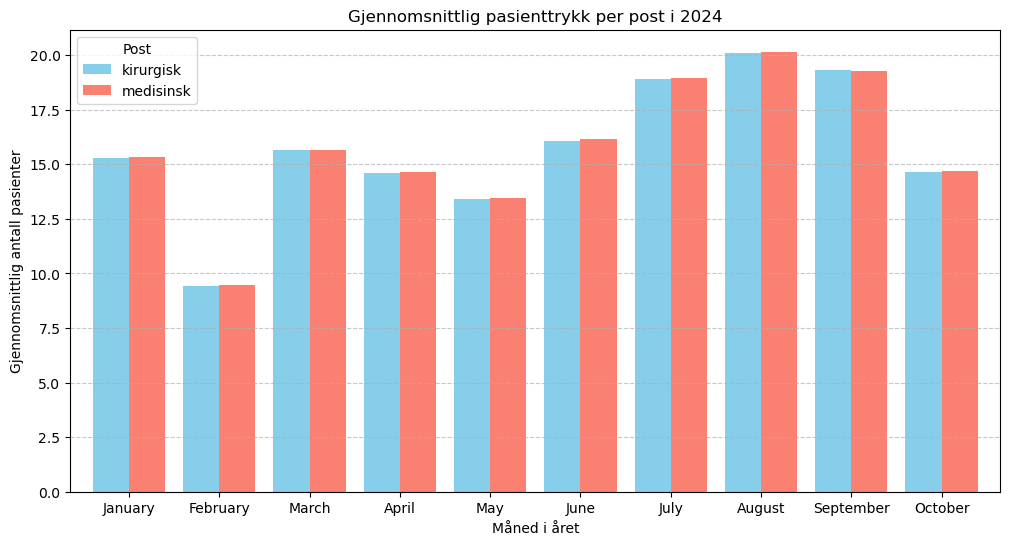

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by timer og post, og finn gjennomsnittet av etterspørselen
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
avg_patients_per_hour = fin_data_hourly_24.groupby(['Måned', 'post'])['Demand'].mean().reset_index()
avg_patients_per_hour['Måned'] = pd.Categorical(avg_patients_per_hour['Måned'], categories=month_order, ordered=True)
avg_patients_per_hour = avg_patients_per_hour.sort_values('Måned')
# Pivot for lettere plotting
pivot_data = avg_patients_per_hour.pivot(index='Måned', columns='post', values='Demand')
pivot_data.plot(kind='bar', width=0.8, figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title("Gjennomsnittlig pasienttrykk per post i 2024")
plt.xlabel("Måned i året")
plt.ylabel("Gjennomsnittlig antall pasienter")
plt.xticks(rotation=0)
plt.legend(title="Post")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
